# Data Processing

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Process Data

### Step 1 - Split matches into point segments

Starting from the full match videos and the annotations, we split them into shorter segments containing a single point.

In [14]:
# Import libraries
import os
import json
import cv2
from tqdm import tqdm

In [15]:
# Constants
from __init__ import data_path
# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
videos_path = os.path.join(dataset_path, "videos")
annotations_path = os.path.join(dataset_path, "annotations")

# Read videos
videos = sorted(os.listdir(videos_path))
print("___VIDEOS___")
for video in videos: print(video)

# Determine where to save segments
segments_path = os.path.join(dataset_path, "segments")
os.makedirs(segments_path, exist_ok=True)

___VIDEOS___
V006.mp4
V007.mp4
V008.mp4
V009.mp4
V010.mp4


In [16]:
def segment_video(
    video, 
    segment_by="Point", 
    videos_path=videos_path, 
    annotations_path=annotations_path, 
    segments_path=segments_path,
    overwrite=False,
):
    # Video & annotation path
    video_name, video_ext = os.path.splitext(video)
    video_path = os.path.join(videos_path, video)
    annotation_path = os.path.join(annotations_path, video.replace(video_ext, ".json"))

    # Load annotation
    with open(annotation_path) as annotation_file:
        annotation = json.load(annotation_file)

    # Load video
    capture = cv2.VideoCapture(video_path)
    frame = 0

    # Get resolution & framerate from capture
    frame_width = int(capture.get(cv2.CAP_PROP_FRAME_WIDTH))
    frame_height = int(capture.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = capture.get(cv2.CAP_PROP_FPS)

    # Perform segmentation
    segments = annotation["classes"][segment_by]
    for index, segment in tqdm(enumerate(segments)):
        # Determine path to save current segment
        segment_nr = f"{index}".zfill(4)
        segment_name = f"{video_name}_{segment_nr}"
        segment_path = os.path.join(segments_path, f"{segment_name}.mp4")

        # Don't overwrite if not needed
        if os.path.exists(segment_path) and not overwrite:
            continue

        # Open video writer
        writer = cv2.VideoWriter(segment_path, cv2.VideoWriter_fourcc(*"avc1"), fps, (frame_width, frame_height))

        # segment points
        start, end = int(segment["start"]), int(segment["end"])

        # Fast forward to start of segment
        frame = start
        capture.set(1, frame)
        
        # Save frames to segment
        while_safety = 0
        max_while_safety = 500
        while frame < end:
            # Read frame
            ret, img = capture.read()

            # Sometimes OpenCV reads None's during a video, in which case we want to just skip
            assert while_safety < max_while_safety, f"ERROR, cv2 read {max_while_safety} Nones"
            if ret == 0 or img is None: 
                while_safety += 1
                continue 
            while_safety = 0

            # Write frame
            writer.write(img)

            # Increase frame counter
            frame += 1
        
        # Release writer
        writer.release()
    

In [17]:
segment_video(videos[0], overwrite=False)

81it [00:00, 79807.05it/s]


In [18]:
for video in videos:
    print(f"Segmenting video {video}")
    segment_video(video, overwrite=False)

81it [00:00, 137157.30it/s]
129it [00:00, 97034.65it/s]
76it [00:00, 128535.12it/s]
366it [00:00, 120865.70it/s]

Segmenting video V006.mp4
Segmenting video V007.mp4
Segmenting video V008.mp4
Segmenting video V009.mp4
Segmenting video V010.mp4



94it [00:00, 100783.38it/s]


In [19]:
segment_files = [f for f in os.listdir(segments_path) if f.endswith('.mp4')]
n_segments = len(segment_files)
total_frames = 0
total_duration = 0
for segment in segment_files:
    segment_path = os.path.join(segments_path, segment)
    # Give the duration and number of frames of the video
    data = cv2.VideoCapture(segment_path) 
    frames = data.get(cv2.CAP_PROP_FRAME_COUNT) 
    fps = data.get(cv2.CAP_PROP_FPS)
    
    # calculate duration of the video 
    duration = frames / fps

    # Add to total
    total_frames += frames
    total_duration += duration

print(f"Total number of videos: {n_segments}")
print(f"Total number of frames: {total_frames}")
print(f"Total duration: {total_duration / 60 / 60:.2f} hours")
print(f"Average duration per video: {total_duration / n_segments:.2f} seconds")

KeyboardInterrupt: 

### Step 2 - Court, Player & Ball Detection

In [2]:
# Import libaries
import os
import sys
import cv2
import numpy as np
import torch
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {device}")

Using device cpu


We make use of the pre-trained models provided by the tennis-project repository:
- [Ball Detection](https://drive.google.com/file/d/1XEYZ4myUN7QT-NeBYJI0xteLsvs-ZAOl/view): Save as `models/data/ball_detection/model.pt`
- [Court Detection](https://drive.google.com/file/d/1f-Co64ehgq4uddcQm1aFBDtbnyZhQvgG/view): Save as `models/data/court_detection/model.pt`

In [3]:
# Constants
from __init__ import data_path, models_path
from data_utils import read_segment_frames, read_segment_labels, visualize_frame_annotations, visualize_segment_labels

# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments")
labels_path = os.path.join(dataset_path, "labels")
os.makedirs(labels_path, exist_ok=True)

# Model paths
model_ball_detection_path = os.path.join(models_path, "ball_detection", "model.pt")
model_court_detection_path = os.path.join(models_path, "court_detection", "model.pt")
assert os.path.exists(model_ball_detection_path), "Please download model"
assert os.path.exists(model_court_detection_path), "Please download model"

In [4]:
# Import tennis-project objects
cwd = os.getcwd()
tennis_project_path = os.path.abspath(os.path.join(cwd, "tennis-project"))
sys.path.append(tennis_project_path)
from court_detection_net import CourtDetectorNet
from court_reference import CourtReference
from bounce_detector import BounceDetector
from person_detector import PersonDetector
from ball_detector import BallDetector
from utils import scene_detect
from main import read_video
from main import get_court_img

/home/florsanders/anaconda3/envs/teco/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
# Read segment files
segment_files = [file for file in sorted(os.listdir(segments_path)) if os.path.splitext(file)[-1] == ".mp4"]
print(f"Number of segment files: {len(segment_files)}")

Number of segment files: 746


In [ ]:
def get_player_bboxes(court_points, person_candidates, is_btm, frame_width=1280, frame_height=720):
    # Setup
    bbox = [None]*4
    court_outline = np.array(kps_court[i][:4])
    
    # Make predictions
    if len(person_candidates) == 0:
        pass
    elif len(person_candidates) == 1:
        bbox = person_candidates[0][0]
    else:
        # Need to filter
        if np.any(court_outline.reshape(-1) == None):
            # We can't base our choice on the court lines... make guess
            print("WARNING: Court points invalid - guessing")
            x_c = frame_width // 2
            y_c = frame_height if is_btm else 0
        else:
            (x_tl, y_tl), (x_tr, y_tr), (x_bl, y_bl), (x_br, y_br) = court_outline
            x_c = (x_bl + x_br) / 2 if is_btm else (x_tl + x_tr) / 2 
            y_c = (y_bl + y_br) / 2 if is_btm else (y_tl + y_tr) / 2
        distances = [(x_player - x_c)**2 + (y_player - y_c)**2 for _, (x_player, y_player) in person_candidates]
        choice_index = np.argmin(distances)
        bbox = person_candidates[choice_index][0]
    
    return bbox

In [6]:
def process_segment(
    segment_path, 
    labels_path = labels_path, 
    verbose = True,
    overwrite=False,
):
    # Start
    start_time = time.time()

    # Check if segment already processed (by last saved file)
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    if os.path.exists(os.path.join(labels_path, f"{segment_name}_ball.npy")) and not overwrite:
        #if verbose: print(f"Segment {segment_name} already processed")
        return
    if verbose: print(f"Processing segment: {segment_name}")

    # Read video
    if verbose: print("Reading video")
    frames, fps =  read_video(segment_path)
    frame_height, frame_width, _ = frames[0].shape
    video_time = time.time()
    if verbose: print(f"Done reading {len(frames)} video frames ({video_time - start_time} s)")

    # Load models
    if verbose: print("Loading models")
    ball_detector = BallDetector(model_ball_detection_path, device)
    court_detector = CourtDetectorNet(model_court_detection_path, device)
    person_detector = PersonDetector(device)
    models_time = time.time()
    if verbose: print(f"Done loading models ({models_time - video_time} s)")

    # Detect court 
    if verbose: print("Detecting court")
    homography_matrices, kps_court = court_detector.infer_model(frames)
    court_time = time.time()
    if verbose: print(f"Done detecting court ({court_time - models_time} s)")

    # Detect whether frames are valid (i.e. court is detected)
    frames_is_valid = np.array([not detection is None for detection in kps_court])
    frames = [frame for frame, frame_is_valid in zip(frames, frames_is_valid) if frame_is_valid]
    homography_matrices = [matrix for matrix, frame_is_valid in zip(homography_matrices, frames_is_valid) if frame_is_valid]
    kps_court = [points for points, frame_is_valid in zip(kps_court, frames_is_valid) if frame_is_valid]

    # Detect people
    if verbose: print("Detecting people")
    persons_top, persons_bottom = person_detector.track_players(frames, homography_matrices, filter_players=False)
    people_time = time.time()
    if verbose: print(f"Done detecting people ({people_time - court_time} s)")

    # Detect ball trajectory
    if verbose: print("Detecting ball trajectory")
    ball_track = ball_detector.infer_model(frames)
    ball_time = time.time()
    if verbose: print(f"Done detecting ball trajectory ({ball_time - people_time} s)")

    # Export labels
    if verbose: print("Saving results")
    # Save frame validities
    frames_is_valid_file = os.path.join(labels_path, f"{segment_name}_frame_validity.npy")
    np.save(frames_is_valid_file, frames_is_valid)
    # Save court
    court_file = os.path.join(labels_path, f"{segment_name}_court.npy")
    court_sequence = np.squeeze(np.array(kps_court))
    np.save(court_file, court_sequence)
    # Save players
    for player_name, player_sequence in zip(["btm", "top"], [persons_bottom, persons_top]):
        player_file = os.path.join(labels_path, f"{segment_name}_player_{player_name}_bbox.npy")
        player_sequence = np.array([get_player_bboxes(kps_court[i], person_candidates, not is_top, frame_width=frame_width, frame_height=frame_height) for i, person_candidates in enumerate(player_sequence)])
        np.save(player_file, player_sequence)
    # Save ball trajectory
    ball_file = os.path.join(labels_path, f"{segment_name}_ball.npy")
    ball_sequence = np.array(ball_track)
    np.save(ball_file, ball_sequence)
    save_time = time.time()
    if verbose: print(f"Done detecting ball trajectory ({save_time - ball_time} s)")
    if verbose: print(f"Total time: {save_time - start_time} s")

In [ ]:
for i, segment_file in enumerate(segment_files):
    process_segment(os.path.join(segments_path, segment_file), overwrite=False, verbose=True)

#### Recompute boxes!!!

Bounding boxes selected the wrong player too often - recomputing

In [ ]:
from homography import get_trans_matrix

In [ ]:
def recompute_bboxes(
    segment_path, 
    labels_path = labels_path, 
    verbose=True,
    overwrite=False,
):
    # Start
    start_time = time.time()

    # Check if segment already processed (by last saved file)
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    if verbose: print(f"Processing segment: {segment_name}")

    # Read segment labels
    if verbose: print("Reading segment labels")
    frames_is_valid, kps_court, _, _, _ = read_segment_labels(
        segment_path,
        labels_path=labels_path,
        load_frame_validity=True,
        load_court=True,
        load_ball=True,
        load_player_bbox=True,
    )

    # Get matrices
    if verbose: print("Get homography matrices")
    homography_matrices = [get_trans_matrix([list(point) if point is not None else None for point in points]) for points in kps_court]
    homography_matrices = [cv2.invert(matrix_trans)[1] if matrix_trans is not None else None for matrix_trans in homography_matrices]
    homography_time = time.time()
    if verbose: print(f"Done getting homography matrices ({homography_time - start_time} s)")

    # Read video
    if verbose: print("Reading video")
    frames, fps =  read_video(segment_path)
    frame_height, frame_width, _ = frames[0].shape
    video_time = time.time()
    # Filter valid frames
    frames = [frame for frame, frame_is_valid in zip(frames, frames_is_valid) if frame_is_valid]
    if verbose: print(f"Done reading {len(frames)} video frames ({video_time - homography_time} s)")

    # Load models
    if verbose: print("Loading models")
    person_detector = PersonDetector(device)
    models_time = time.time()
    if verbose: print(f"Done loading models ({models_time - video_time} s)")

    # Detect people
    if verbose: print("Detecting people")
    persons_top, persons_bottom = person_detector.track_players(frames[:3], homography_matrices, filter_players=False)
    people_time = time.time()
    if verbose: print(f"Done detecting people ({people_time - models_time} s)")

    # Export labels
    if verbose: print("Saving results")
    # Save players
    player_bboxes = []
    for is_top, (player_name, player_sequence) in enumerate(zip(["btm", "top"], [persons_bottom, persons_top])):
        player_file = os.path.join(labels_path, f"{segment_name}_player_{player_name}_bbox.npy")
        player_sequence = np.array([get_player_bboxes(kps_court[i], person_candidates, not is_top, frame_width=frame_width, frame_height=frame_height) for i, person_candidates in enumerate(player_sequence)])
        player_bboxes.append(player_sequence)
        #np.save(player_file, player_sequence)
    save_time = time.time()
    if verbose: print(f"Total time: {save_time - start_time} s")

    return frames, player_bboxes[0], player_bboxes[1], kps_court

In [ ]:
frames, bottom_bboxes, top_bboxes, kps_court = recompute_bboxes(
    os.path.join(segments_path, "V008_0038.mp4"),
)

Processing segment: V008_0038
Reading segment labels
Get homography matrices
Done getting homography matrices (0.13492894172668457 s)
Reading video
Done reading 128 video frames (0.21376872062683105 s)
Loading models


/home/florsanders/anaconda3/envs/teco/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/florsanders/anaconda3/envs/teco/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/3 [00:00<?, ?it/s]

Done loading models (0.5164759159088135 s)
Detecting people


100%|██████████| 3/3 [00:07<00:00,  2.62s/it]

Done detecting people (7.8712708950042725 s)
Saving results
Total time: 8.736719608306885 s


In [ ]:
print(len(kps_court))

128


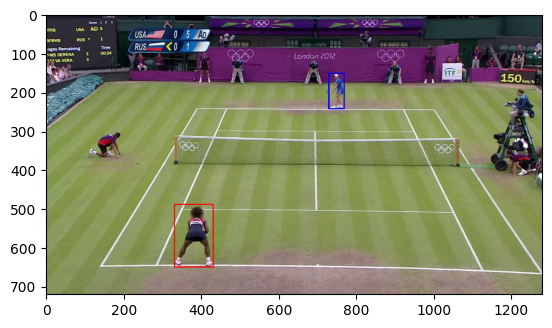

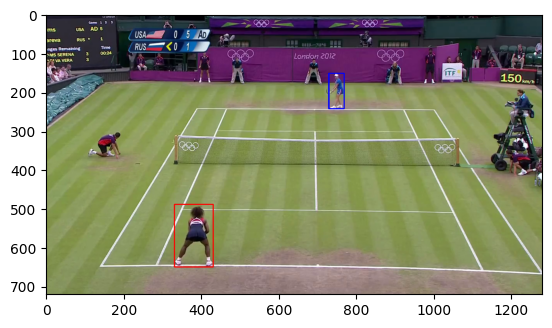

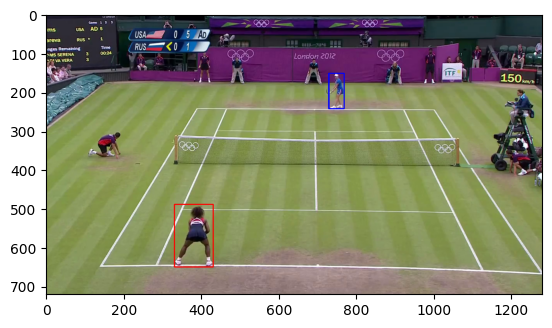

In [ ]:
n_frames = len(bottom_bboxes)
colors = [(255, 0, 0), (0, 0, 255)]
for i in range(n_frames):
    img = frames[i].copy()
    
    for j, bboxes in enumerate([top_bboxes, bottom_bboxes]):
        for k, bbox in enumerate(bboxes):
            x1, y1, x2, y2 = bbox
            img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), colors[j], 2)

    # Show img
    fig, ax = plt.subplots()
    ax.imshow(img[:,:,::-1])
    plt.show()

In [ ]:
# Video writer
fourcc = cv2.VideoWriter_fourcc(*"avc1")
writer = cv2.VideoWriter("./video.mp4", fourcc, 25, (1280, 720))

# Visualize & write video
colors = [(255, 0, 0), (0, 0, 255)]
for i, frame in enumerate(frames):
    # Skip invalid frames
    img = frames[i].copy()
    
    for j, bboxes in enumerate([top_bboxes[i], bottom_bboxes[i]]):
        x1, y1, x2, y2 = bbox
        if x1 is None or y1 is None or x2 is None or y2 is None:
            continue
        img = cv2.rectangle(img, (int(x1), int(y1)), (int(x2), int(y2)), colors[j], 2)

    writer.write(img)
    frame_index += 1

# Release video
writer.release()

### Step 3 - Player Pose Detection

In [5]:
# Import libraries
import os
import sys
import numpy as np
import cv2
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device {device}")

Using device cpu


In [6]:
# Constants
from __init__ import data_path, models_path
from data_utils import read_segment_frames, read_segment_labels, visualize_frame_annotations, visualize_segment_labels

# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments")
labels_path = os.path.join(dataset_path, "labels")

In [7]:
# Read segment files
segment_files = [file for file in sorted(os.listdir(segments_path)) if os.path.splitext(file)[-1] == ".mp4"]
print(f"Number of segment files: {len(segment_files)}")

Number of segment files: 746


In [9]:
# Load pose model
from mmpose.apis import MMPoseInferencer
inferencer = MMPoseInferencer('human')

In [342]:
def clean_bbox_sequence(
    bbox_sequence, 
    court_sequence, 
    is_btm,
    derivative_threshold=5000,
    make_plot=False,
):
    # Look at center points to gather inconsistencies
    center_points = np.zeros((len(bbox_sequence), 2))
    bbox_areas = np.zeros(len(bbox_sequence))
    bbox_sequence_clean = np.copy(bbox_sequence)
    missing_points = np.zeros(len(center_points), dtype=int)

    # Extract center points wrt court from 
    for i, (bbox, court_points) in enumerate(zip(bbox_sequence, court_sequence)):
        # Skip no bounding box detected
        if np.any(bbox == None):
            center_points[i, :] = np.inf
            continue
        xb1, yb1, xb2, yb2 = bbox
        bbox_areas[i] = np.abs((xb2 - xb1) * (yb2 - yb1))

        # Skip no court outline detected
        court_outline = court_points[:4]
        if np.any(court_outline == None):
            center_points[i, :] = np.inf
            continue
        
        # Get relevant center point of the court
        (xtl, ytl), (xtr, ytr), (xbl, ybl), (xbr, ybr) = court_outline
        x_ref = (xbl + xbr) / 2 if is_btm else (xtl + xtr) / 2
        y_ref = (ybl + ybr) / 2 if is_btm else (ytl + ytr) / 2

        # Get center point of the player's feet
        x_player = (xb1 + xb2) / 2
        y_player = yb2

        # Save player center point referenced to court point
        center_points[i, 0] = x_player - x_ref
        center_points[i, 1] = y_player - y_ref

    # Compute first derivative
    center_points_derivative = np.vstack(([[0, 0]], center_points[:-1] - center_points[1:]))
    center_points_derivative = center_points_derivative[:,0]**2 + center_points_derivative[:,1]**2
    bbox_areas_derivative = np.abs(np.concatenate(([0], bbox_areas[:-1] - bbox_areas[1:])))

    # Area jumps
    bbox_area_jumps = np.sort(np.argwhere(bbox_areas_derivative > derivative_threshold).reshape(-1))
    if len(bbox_area_jumps):
        # print("JUMPS DETECTED")
        # print(bbox_area_jumps)
        mean_area = np.mean(bbox_areas[:bbox_area_jumps[0]])
    else:
        mean_area = np.mean(bbox_areas)

    # Determine jump points
    jump_points = np.argwhere(np.logical_or(
        center_points_derivative > derivative_threshold,
        bbox_areas < mean_area / 2,
    )).reshape(-1)
    
    # Return if no cleaning needs to be done
    if len(jump_points) == 0:
        return missing_points.astype(bool), bbox_sequence_clean

    # Process jump points
    indx_last = None
    missing_start = False
    for indx in jump_points:
        #print(indx_last, indx)
        if indx_last is None:
            # First missing point
            #print("FIRST MISSING POINT")
            missing_points[indx] = 1
            missing_start = True
        elif np.any(bbox_sequence[indx] == None):
            # Missing point
            #print("MISSING POINT", indx)
            missing_points[indx] = 1
            missing_start = False
        elif indx_last == indx - 1:
            # Subsequent problematic points
            #print("SUBSEQUENT MISSING POINT")
            missing_points[indx] = 1
            missing_start = False
        else:
            # Distance between missing points
            #print("DISTANCE BETWEEN MISSING POINTS")
            if missing_start:
                # End point (hopefully)
                missing_points[indx_last:indx+1] = 1
                missing_start = False
            else:
                # Start point (hopefully)
                missing_points[indx] = 1
                missing_start = True

        # Update last indx
        indx_last = indx

    # Fill gaps in missing points by linear interpolation
    filled_center_points = np.copy(center_points)
    missing_starts = np.argwhere((missing_points[1:] - missing_points[:-1]) == 1).reshape(-1)
    missing_ends = np.argwhere((missing_points[1:] - missing_points[:-1]) == -1).reshape(-1)
    for i, missing_start in enumerate(missing_starts):
        # Get start value
        if missing_start != 0:
            # Previous value
            cp_start_value = filled_center_points[missing_start-1]
            bbox_start_value = bbox_sequence_clean[missing_start-1]
        else:
            # First valid value (TODO: fix if none is valid???)
            cp_start_value = filled_center_points[not missing_points.astype(bool)][0]
            bbox_start_value = bbox_sequence_clean[not missing_points.astype(bool)][0]

        # Get missing end
        if len(missing_ends) <= i:
            # No matched endpoint - constant from startpoint onward
            missing_end = len(filled_center_points) - 1
            cp_end_value = cp_start_value
            bbox_end_value = bbox_start_value
        else:
            # Get endpoint
            missing_end = missing_ends[i]
            cp_end_value = filled_center_points[missing_end]
            bbox_end_value = bbox_sequence_clean[missing_end]
            
        # Linearly interpolate
        n_points = missing_end - missing_start + 1
        filled_center_points[missing_start:missing_end+1] = np.linspace(cp_start_value, cp_end_value, n_points)
        bbox_sequence_clean[missing_start:missing_end+1] = np.linspace(bbox_start_value, bbox_end_value, n_points)

    if make_plot:
        # Plot results
        fig, ax = plt.subplots()
        ax.plot(center_points[:, 0], label="x", color="tab:blue")
        ax.plot(center_points[:, 1], label="y", color="tab:red")
        ax.plot(filled_center_points[:, 0], label="x filtered", color="tab:cyan")
        ax.plot(filled_center_points[:, 1], label="y filtered", color="tab:orange")
        ax.grid(True)
        ax.legend()
        ax.set_title("Bottom Player" if is_btm else "Top Player")
        plt.show()

        # fig, ax = plt.subplots()
        # ax.plot(bbox_sequence[:, 0], label="x", color="tab:blue")
        # ax.plot(bbox_sequence_clean[:, 0], label="x filtered", color="tab:cyan")
        # ax.plot(bbox_sequence[:, 1], label="y", color="tab:red")
        # ax.plot(bbox_sequence_clean[:, 1], label="y filtered", color="tab:orange")
        # ax.grid(True)
        # plt.show()

        # Plot first derivative
        # fig, ax = plt.subplots()
        # ax.plot(center_points_derivative, color="tab:blue")
        # ax.set_ylim(0, 2*derivative_threshold)
        # ax.grid(True)
        # ax.set_title("Bottom Player" if is_btm else "Top Player")
        # ax.axhline(derivative_threshold, color="tab:orange")
        # plt.show()
    
    return missing_points.astype(bool), bbox_sequence_clean

In [395]:
def detect_pose(
    frame, 
    bbox, 
    crop_padding=50, 
    crop_img_width=256,
    visualize_img=False,
):
    # Initialize empty keypoints
    best_keypoints = np.array([[None, None]] * 17)
    best_bbox = np.array([None, None, None, None])

    # Frame size
    frame_height, frame_width = frame.shape[:2]

    # Parse bounding box coords
    if np.any(bbox == None):
        return best_keypoints, best_bbox
    x1, y1, x2, y2 = bbox
    xc, yc =  (x1 + x2) / 2, (y1 + y2) / 2
    w, h = abs(x2 - x1), abs(y2 - y1)
    d = max(w, h) + crop_padding * 2

    # Define cropping indices
    x_crop1, x_crop2 = int(xc - d/2), int(xc + d/2)
    y_crop1, y_crop2 = int(yc - d/2), int(yc + d/2)

    # Make sure we don't crop past the edges of the frame
    x_crop_offset = min(frame_width - x_crop2, max(-x_crop1, 0))
    y_crop_offset = min(frame_height - y_crop2, max(-y_crop1, 0))
    x_crop1 += x_crop_offset
    x_crop2 += x_crop_offset
    y_crop1 += y_crop_offset
    y_crop2 += y_crop_offset
    
    # Crop image
    img = frame[y_crop1:y_crop2,  x_crop1:x_crop2].copy()

    # Resize img
    scale = d / crop_img_width
    img = cv2.resize(img, (crop_img_width, crop_img_width))

    # Detect pose
    result_generator = inferencer(img, show=False)
    results = [result for result in result_generator]

    # Keep best results
    min_center_distance = np.inf
    for result in results:
        for prediction in result["predictions"]:
            for item in prediction:
                # Parse item
                pose_bbox = item["bbox"]
                keypoints = item["keypoints"]

                # Parse bbox
                xb1, yb1, xb2, yb2 = pose_bbox[0]
                center_x = (xb1 + xb2) / 2
                center_y = (yb1 + yb2) / 2
                center_distance = ((crop_img_width / 2 - center_x)**2  + (crop_img_width / 2 - center_y)**2)**(1/2)

                # Keep track of best prediction
                if center_distance < min_center_distance:
                    min_center_distance = center_distance
                    best_keypoints = keypoints
                    best_bbox = pose_bbox[0]

    # Visualize img
    if visualize_img:
        if not np.any(best_keypoints == None):
            for i, keypoint in enumerate(best_keypoints):
                cv2.circle(img, (int(keypoint[0]), int(keypoint[1])), radius=3, color=(150, 150, 50), thickness=-1)
            x1, y1, x2, y2 = best_bbox
            cv2.rectangle(
                img, (int(x1), int(y1)), (int(x2), int(y2)), (150, 150, 50), 2
            )
        fig, ax = plt.subplots()
        ax.imshow(img[:,:,::-1])
        plt.show()
    
    # Rescale to frame reference
    best_bbox = np.array(best_bbox)
    best_keypoints = np.array(best_keypoints)
    if not np.any(best_keypoints == None):
        best_keypoints *= scale
        best_keypoints[:, 0] += x_crop1
        best_keypoints[:, 1] += y_crop1
        best_bbox *= scale
        best_bbox[0] += x_crop1
        best_bbox[1] += y_crop1
        best_bbox[2] += x_crop1
        best_bbox[3] += y_crop1


    return best_keypoints, best_bbox

```
0 = nose
1, 2 = eyes
3, 4 = ears
5, 6 = shoulders
7, 8 = elbows
9, 10 = hands
11, 12 = hips
13, 14 = knees
15, 16 = feet
```

In [402]:
def process_segment(
    segment_path, 
    labels_path=labels_path,
    crop_padding=50,
    crop_width=224,
    visualize_frame=False,
):
    # Load frames
    segment_dir, segment_filename = os.path.split(segment_path)
    segment_name, segment_ext = os.path.splitext(segment_filename)
    frames, fps = read_segment_frames(segment_path, labels_path=labels_path, load_valid_frames_only=True)
    if not len(frames):
        return False

    # Load labels
    (
        _,
        court_sequence,
        _,
        player_btm_bbox_sequence,
        player_top_bbox_sequence,
        _,
        _,
    ) = read_segment_labels(
        segment_path, 
        labels_path=labels_path,
        load_frame_validity=True,
        load_court=True,
        load_ball=False,
        load_player_bbox=True,
        load_player_pose=False,
        use_pose_bbox=False,
    )

    btm_missing_points, btm_bbox_clean = clean_bbox_sequence(
        player_btm_bbox_sequence,
        court_sequence,
        is_btm=True,
        make_plot=True,
    )
    top_missing_points, top_bbox_clean = clean_bbox_sequence(
        player_top_bbox_sequence,
        court_sequence,
        is_btm=False,
        make_plot=True,
    )

    # Process frames
    players_bbox_last = [None, None]
    players_bbox_sequences = [[None] *  len(frames) , [None] * len(frames)]
    players_pose_sequences = [[None] *  len(frames) , [None] * len(frames)]
    for frame_index, frame in tqdm(enumerate(frames)):
        # Get frame labels
        frame_height, frame_width, _ = frame.shape
        players_bbox = [player_top_bbox_sequence[frame_index], player_btm_bbox_sequence[frame_index]]
        players_bbox_clean = [top_bbox_clean[frame_index], btm_bbox_clean[frame_index]]
        players_missing = [top_missing_points[frame_index], btm_missing_points[frame_index]]

        # Perform pose detection
        for is_btm, bbox in enumerate(players_bbox):
            if players_missing[is_btm]:
                # Try to recover player pose from best knowledge
                for i, bbox_candidate in enumerate([players_bbox_last[is_btm], players_bbox_clean[is_btm], players_bbox[is_btm]]):
                    # Skip invalid bboxes
                    if bbox_candidate is None:
                        continue
                    
                    # Detect pose
                    pose_keypoints, pose_bbox = detect_pose(
                        frame, 
                        bbox_candidate, 
                        crop_padding=crop_padding, 
                        crop_img_width=crop_width,
                        visualize_img=False,
                    )

                    # Break if result is valid
                    if not np.any(pose_keypoints == None):
                        break
            else:
                # Detect pose
                pose_keypoints, pose_bbox = detect_pose(
                    frame, 
                    bbox, 
                    crop_padding=crop_padding, 
                    crop_img_width=crop_width,
                    visualize_img=False,
                )

            # Update last bbox
            players_bbox_last[is_btm] = pose_bbox

            # Save bounding box & pose
            players_bbox_sequences[is_btm][frame_index] = pose_bbox
            players_pose_sequences[is_btm][frame_index] = pose_keypoints

            # Visualize on frame
            if visualize_frame and not np.any(pose_keypoints == None):
                for keypoint in pose_keypoints:
                    cv2.circle(frame, (int(keypoint[0]), int(keypoint[1])), radius=5, color=(150, 150, 50), thickness=-1)
                x1, y1, x2, y2 = pose_bbox
                cv2.rectangle(frame, (int(x1), int(y1)), (int(x2), int(y2)), (150, 150, 50), 2)
                    

        # Visualize frame
        if visualize_frame:
            img = visualize_frame_annotations(
                frame, 
                court_sequence[frame_index], 
                None, 
                players_bbox[1], 
                players_bbox[0], 
                show_court_numbers=False, 
                show_img=True,
            )

    # Export labels
    for is_btm in range(2):
        player_name = "btm" if is_btm else "top"
        player_bbox_file = os.path.join(labels_path, f"{segment_name}_player_{player_name}_bbox_pose.npy")
        player_pose_file = os.path.join(labels_path, f"{segment_name}_player_{player_name}_pose.npy")
        np.save(player_bbox_file, players_bbox_sequences[is_btm])
        np.save(player_pose_file, players_pose_sequences[is_btm])

    return True

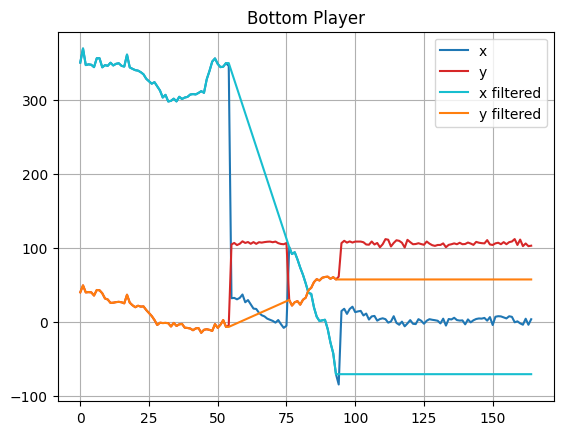

148it [02:37,  1.03s/it]

In [403]:
success = process_segment(os.path.join(segments_path, "V009_0061.mp4"), visualize_frame=False)

## Visualize Processed Data

In [397]:
# Import libaries
import os
import sys
import time
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm

# Constants
from __init__ import data_path, models_path
from data_utils import read_segment_frames, read_segment_labels, visualize_frame_annotations, visualize_segment_labels

# Choose dataset
dataset = "tenniset"
dataset_path = os.path.join(data_path, dataset)
segments_path = os.path.join(dataset_path, "segments")
labels_path = os.path.join(dataset_path, "labels")

In [401]:
visualize_segment_labels(os.path.join(segments_path, "V009_0061.mp4"), overwrite=True)

'/home/florsanders/Code/columbia_university/advanced_deep_learning/adl_ai_tennis_coach/data/tenniset/segments/../labels/V009_0044_annotated.mp4'

In [ ]:
for segment_file in tqdm(segment_files):
    out_path = visualize_segment_labels(os.path.join(segments_path, segment_file), overwrite=False)